In [ ]:
   '''
The architecture for the GAN consists of 2 sections: Generator and Discriminator. 

The Generator architecture follows the UNet architecture found in the image below (Also shown in the project proposal).

The Discriminator Architercture uses similar to bselines contractive path. 

We use a series of convolutional blocks that are consistent of the following: 

    -- nn.conv2d
    -- nn.BatchNorm2d
    -- nn.ReLU or nn.LeakyReLU

We create a class that returns a block of the above components using nn.Sequential.
'''

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Convolutional block using ReLU
class ConvBlock_Relu(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=2, padding=1, bias=True):
        super(ConvBlock_Relu, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_size),
        nn.ReLU() 
        )

    def forward(self, x):
        x = self.model(x)
        return x

#Convolutional block using Leaky ReLU
class ConvBlock_Leaky_Relu(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=2, padding=1, bias=True):
        super(ConvBlock_Leaky_Relu, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_size),
        nn.LeakyReLU(0.2) 
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [3]:
#DeConvolutional block using ReLU
class DeconvBlock_Relu(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=2, padding=1, output_padding=0, bias=True):
        super(DeconvBlock_Relu, self).__init__()

        self.model = nn.Sequential(
          nn.ConvTranspose2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=output_padding, bias=bias),
          nn.BatchNorm2d(out_size),
          nn.ReLU() 
        )

    def forward(self, x):
        x = self.model(x)
        return x

#DeConvolutional block using Leaky ReLU
class DeconvBlock_Leaky_Relu(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=2, padding=1,output_padding=0, bias=True):
        super(DeconvBlock_Relu, self).__init__()

        self.model = nn.Sequential(
          nn.ConvTranspose2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=output_padding, bias=bias),
          nn.BatchNorm2d(out_size),
          nn.LeakyReLU(0.2) 
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
#Generator Model Class
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        #Convolutional layers
        self.conv1 = ConvBlock_Relu(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv2 = ConvBlock_Relu(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = ConvBlock_Relu(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv4 = ConvBlock_Relu(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5 = ConvBlock_Relu(512, 512, kernel_size=3, stride=2, padding=1, bias=False)

        #Deconvolutional layers
        self.deconv1 = DeconvBlock_Relu(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv2 = DeconvBlock_Relu(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1,bias=False)
        self.deconv3 = DeconvBlock_Relu(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1,bias=False)
        self.deconv4 = DeconvBlock_Relu(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1,bias=False)
        self.deconv5 = DeconvBlock_Relu(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1,bias=False)

        self.conv7 = ConvBlock_Relu(128, 2, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        #Encoding layers
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        #Decoding Layers
        x6 = self.deconv1(x5) + x4
        x7 = self.deconv2(x6) + x3
        x8 = self.deconv3(x7) +x2
        x9 = self.deconv4(x8) + x1
        x10 = self.deconv5(x9)

        x11 = torch.tanh(x10)
        return x11

  

In [5]:
#Dscriminator Model Class
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        self.conv1 = ConvBlock_Relu(3, 64, kernel_size=3, stride=2, padding=1, bias = False)
        self.conv2 = ConvBlock_Relu(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = ConvBlock_Relu(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv4 = ConvBlock_Relu(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5 = ConvBlock_Relu(512, 512, kernel_size=3, stride=2, padding=0, bias=False)
        self.conv6 = ConvBlock_Relu(512, 1, kernel_size=1, stride=1, padding=0, bias=False)
        #self.conv7 = ConvBlock_Relu(512, 1, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(36, 1)

    def forward(self, x):
        #Convolutional Layers with pooling in between
        x1 = self.conv1(x)
        #x2 = self.pool(x1)
        x3 = self.conv2(x1)
        #x4 = self.pool(x3)
        x5 = self.conv3(x3)
        #x6 = self.pool(x5)
        x7 = self.conv4(x5)
        #x8 = self.pool(x7)
        x9 = self.conv5(x7)
        #x10 = self.pool(x9)

        #Fully connected layers
        x11 = self.conv6(x9)
        x12 = x11.view(-1, 36)
        x13 = self.fc(x12)
        return torch.sigmoid(x13)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import cv2

import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.utils.data as Data
from torch.autograd import Variable
from skimage import color

# import tensorflow as tf
# import tensorflow_datasets as tfds

torch.manual_seed(1)
np.random.seed(1000)

In [9]:
#Adrians Data Loaders
from google.colab import drive
drive.mount('/content/drive')
master_path = '/content/drive/My Drive/Year 3 Groupwork/APS360 Project/Code and Core Project/Datasets/Flickr30k Dataset/flickr30k_images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_dir = '/content/drive/My Drive/Year 3 Groupwork/APS360 Project/Code And Core Project/Datasets/Flickr30k Dataset/'
# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

main_dataset = datasets.ImageFolder(data_dir, transform=data_transform)

# print out some data stats
print('Num of input images: ', len(main_dataset))

Num of input images:  11080


In [11]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # # Check if the label is in the target classes
        # label_index = dataset[i][1] # ex: 3
        # label_class = classes[label_index] # ex: 'cat'
        # if label_class in target_classes:
          indices.append(i)
    return indices

def get_data_loader(dataset, batch_size, splt_1, splt_2):
    """ Loads images of hands, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    ########################################################################

    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(dataset)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split1 = int(len(relevant_indices) * splt_1) #split1 at 75%
    split2 = int(len(relevant_indices) * splt_2) #split1 at 90%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split1], relevant_indices[split1:split2], relevant_indices[split2:]   
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    
    print('Number of train images: ', len(relevant_train_indices))
    print('Number of validation images: ', len(relevant_val_indices))
    print('Number of testing images: ', len(relevant_test_indices))
    return train_loader, val_loader, test_loader

###############################################################################

In [16]:
###############################################################################
BATCH_SIZE = 1

train_loader, val_loader, test_loader = get_data_loader(
    dataset=main_dataset,
    batch_size=BATCH_SIZE, 
    splt_1=0.1, 
    splt_2=0.95) 

Number of train images:  1108
Number of validation images:  9418
Number of testing images:  554


In [17]:
def train_GAN(generator_model, discriminator_model, train_loader, val_loader, lmda, batch_size=256, num_epochs=10, lr=0.001):
    iters = []
    #Setup For Generator
    criterion_gen = nn.BCELoss()
    criterion_gen_2 = nn.L1Loss()
    optimizer_gen = optim.Adam(generator_model.parameters(), lr=lr)
    gen_losses, gen_train_acc, gen_val_acc = [], [], []

    #Discriminator Setup
    criterion_disc = nn.BCELoss()
    optimizer_disc = optim.Adam(discriminator_model.parameters(), lr=lr)
    disc_losses, disc_train_acc, disc_val_acc = [], [], []

    generator_model.train()
    discriminator_model.train()
    for epoch in range(num_epochs):
        print('epoch #: ' + str(epoch))
        real_found = 0
        real_count = 0
        fake_count = 0
        fake_found = 0
        count = 0
        for step, (img_lab, clas) in enumerate(train_loader):
            #if(count %100 == 0):
              #print(count)
            count+=1
            #####Discriminator Training ######
            optimizer_disc.zero_grad()
            img_gray = img_lab[:,0:1,:,:]
            #Train with real images
           # print("real training")

            out_real_disc = discriminator_model(img_lab)
            if(out_real_disc > 0.5):
              real_found +=1
            real_count+=1
            
            #print(out_real_disc.shape)
            label_real = torch.FloatTensor(img_lab.size(0)).fill_(1)
            label_real_v = Variable(label_real)
            #print(label_real_v)
            real_labels = torch.ones(img_lab.shape[0], 1)
            loss_real_disc = criterion_disc(out_real_disc , real_labels.float())

            #Train with fake images
            fake_data =  generator_model(img_gray)
            out_fake_disc = discriminator_model(fake_data.detach())
            if(out_fake_disc < 0.5):
              fake_found +=1
            fake_count +=1
            label_fake = torch.FloatTensor(fake_data.size(0)).fill_(0)
            label_fake_v = Variable(label_fake)
            fake_labels = torch.zeros(img_lab.shape[0], 1)
            loss_fake_disc = criterion_disc(out_fake_disc, fake_labels.float())

            loss_disc = (loss_fake_disc + loss_real_disc) /2
            loss_disc.backward()
            optimizer_disc.step()


            #####Generator Training ######
            optimizer_gen.zero_grad()
            disc_out = discriminator_model(fake_data)
            loss_GAN = criterion_gen(disc_out, real_labels)
            loss_l1 = criterion_gen_2(fake_data.view(fake_data.size(0),-1), img_lab.view(img_lab.size(0),-1))
            loss_gen = (1.0-lmda) * loss_GAN + lmda*loss_l1;
            

            loss_gen.backward()
            optimizer_gen.step()
        
        iters.append(epoch)
        gen_losses.append(float(loss_gen)/batch_size)
        disc_losses.append(float(loss_disc)/batch_size)
        print('gen loss: ' + str(float(loss_gen)) + ' | disc_loss: ' + str(float(loss_disc)))
        print("correctly identified real: " + str(real_found) + " / " + str(real_count))
        print("correctly identified fake: " + str(fake_found) + " / " + str(fake_count))
        print("total count", count)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, gen_losses, label="Gen Losses")
    plt.plot(iters, disc_losses, label="Disc Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()



In [ ]:
gen_model = GeneratorModel()
disc_model = DiscriminatorModel()

train_GAN(generator_model=gen_model, discriminator_model=disc_model, train_loader=train_loader, val_loader=val_loader,num_epochs=30, lmda=0.98)

In [ ]:
fake_found = 0
tot_count = 0
for step, (img_lab, clas) in enumerate(test_loader):
      grey_img = img_lab[:,0:1,:,:]
      tot_count +=1
      output = gen_model(grey_img)
      out_fake_disc = disc_model(output.detach())
      if(out_fake_disc < 0.5):
          fake_found +=1

print("It detected the following number of generated images as fake" + str(fake_found) + "/" + str(tot_count))


It detected the following number of generated images as fake518/554


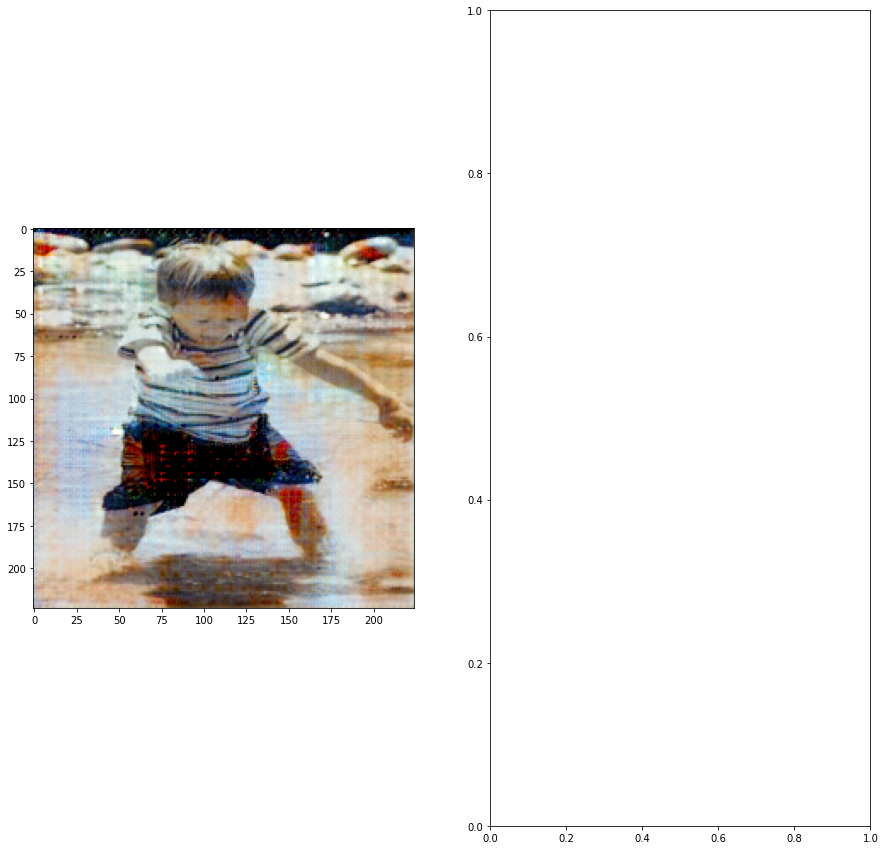

In [ ]:
test_count = 0
import random
from skimage import color, io
predicted_rgb_batch = []
num = random.randint(0,1000)
for step, (img_lab, clas) in enumerate(test_loader):
    grey_img = img_lab[:,0:1,:,:]
    output = gen_model(grey_img)
    out_fake_disc = disc_model(output.detach())
    if(out_fake_disc < 0.5):
        predicted_rgb_img = color.lab2rgb(np.transpose(output[0].detach().numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(output[0]))
        break

fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).detach().numpy(), (1, 2, 0)))
plt.show()

In [24]:
###############################################################################
BATCH_SIZE = 1

train_loader, val_loader, test_loader = get_data_loader(
    dataset=main_dataset,
    batch_size=BATCH_SIZE, 
    splt_1 =0.001, 
    splt_2 = 0.95) 

Number of train images:  11
Number of validation images:  10515
Number of testing images:  554


epoch #: 0
gen loss: 0.09623008221387863 | disc_loss: 0.12132591754198074
correctly identified real: 10 / 11
correctly identified fake: 11 / 11
total count 11
epoch #: 1
gen loss: 0.13625724613666534 | disc_loss: 1.2280571460723877
correctly identified real: 10 / 11
correctly identified fake: 9 / 11
total count 11
epoch #: 2
gen loss: 0.06796763837337494 | disc_loss: 0.42939573526382446
correctly identified real: 10 / 11
correctly identified fake: 10 / 11
total count 11
epoch #: 3
gen loss: 0.06315983831882477 | disc_loss: 0.045091867446899414
correctly identified real: 9 / 11
correctly identified fake: 11 / 11
total count 11
epoch #: 4
gen loss: 0.06090833619236946 | disc_loss: 0.7509978413581848
correctly identified real: 10 / 11
correctly identified fake: 7 / 11
total count 11
epoch #: 5
gen loss: 0.09613431245088577 | disc_loss: 0.06346327066421509
correctly identified real: 8 / 11
correctly identified fake: 10 / 11
total count 11
epoch #: 6
gen loss: 0.05003361031413078 | disc_los

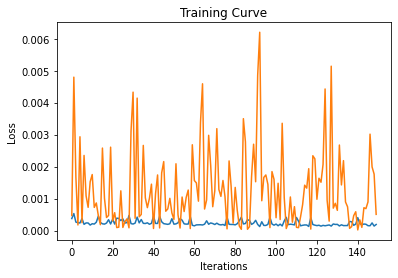

In [27]:
gen_model_2 = GeneratorModel()
disc_model_2 = DiscriminatorModel()

train_GAN(generator_model=gen_model, discriminator_model=disc_model, train_loader=train_loader, val_loader=val_loader,num_epochs=150, lmda=0.995)

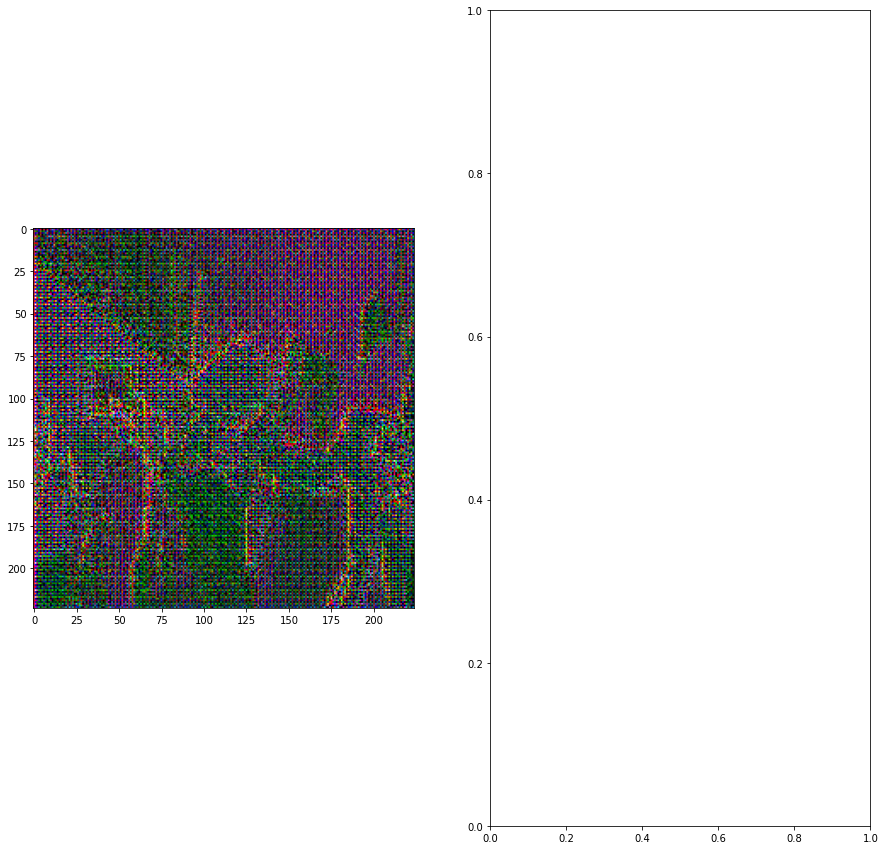

In [31]:
test_count = 0
import random
from skimage import color, io
predicted_rgb_batch = []
num = random.randint(0,1000)
for step, (img_lab, clas) in enumerate(train_loader):
    grey_img = img_lab[:,0:1,:,:]
    output = gen_model_2(grey_img)
    out_fake_disc = disc_model_2(output.detach())
    if(out_fake_disc < 0.5):
        predicted_rgb_img = color.lab2rgb(np.transpose(output[0].detach().numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(output[0]))
        break

fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).detach().numpy(), (1, 2, 0)))
plt.show()